In [9]:
# Experiment 3 KD with a smaller model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [5]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [6]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()    
    model.add(layers.Dense(32, activation='relu'))
        
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [7]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [8]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 3ms/step - mse: 4204.4058 - mae: 21.4924 - mape: 1405.0776 - student_loss: 21.4120 - distillation_loss: 4188.4559 - val_mse: 4.4577 - val_mae: 1.8582 - val_mape: 96.6239 - val_student_loss: 1.9486
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 4.4578 - mae: 1.8508 - mape: 94.5089 - student_loss: 1.8518 - distillation_loss: 3.9873 - val_mse: 4.2353 - val_mae: 1.8176 - val_mape: 93.2111 - val_student_loss: 1.9249
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 4.2589 - mae: 1.8172 - mape: 92.1727 - student_loss: 1.8181 - distillation_loss: 3.7940 - val_mse: 4.1118 - val_mae: 1.7831 - val_mape: 90.8056 - val_student_loss: 1.8909
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 4.1121 - mae: 1.7770 - mape: 89.4085 - student_loss: 1.7774 - distillation_loss: 3.6526 - val_mse: 3.9534 - val_mae: 1.7381 - val_mape: 87.6938 - val_student_loss: 1.8460
Epo

443/443 [==============================] - 1s 2ms/step - mse: 0.9537 - mae: 0.7829 - mape: 55.9951 - student_loss: 0.7837 - distillation_loss: 0.5145 - val_mse: 0.9325 - val_mae: 0.7723 - val_mape: 56.8861 - val_student_loss: 1.1453
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9539 - mae: 0.7827 - mape: 55.9463 - student_loss: 0.7822 - distillation_loss: 0.5159 - val_mse: 0.9325 - val_mae: 0.7728 - val_mape: 57.0253 - val_student_loss: 1.1460
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9538 - mae: 0.7825 - mape: 55.8977 - student_loss: 0.7815 - distillation_loss: 0.5152 - val_mse: 0.9325 - val_mae: 0.7739 - val_mape: 57.3423 - val_student_loss: 1.1478
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9535 - mae: 0.7837 - mape: 56.2063 - student_loss: 0.7848 - distillation_loss: 0.5160 - val_mse: 0.9327 - val_mae: 0.7711 - val_mape: 56.5437 - val_student_loss: 1.1434
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9537 - mae: 0.7829 - mape: 55.9740 - student_loss: 0.7821 - distillation_loss: 0.5149 - val_mse: 0.9325 - val_mae: 0.7729 - val_mape: 57.0655 - val_student_loss: 1.1463
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9538 - mae: 0.7829 - mape: 55.9812 - student_loss: 0.7838 - distillation_loss: 0.5174 - val_mse: 0.9325 - val_mae: 0.7729 - val_mape: 57.0595 - val_student_loss: 1.1462
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9538 - mae: 0.7828 - mape: 55.9814 - student_loss: 0.7844 - distillation_loss: 0.5147 - val_mse: 0.9325 - val_mae: 0.7737 - val_mape: 57.2705 - val_student_loss: 1.1474
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9536 - mae: 0.7833 - mape: 56.0904 - student_loss: 0.7821 - distillation_loss: 0.5145 - val_mse: 0.9325 - val_mae: 0.7728 - val_mape: 57.0386 - val_student_loss: 1.1461
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.9539 - mae: 0.7828 - mape: 55.9560 - student_loss: 0.7821 - distillation_loss: 0.5165 - val_mse: 0.9325 - val_mae: 0.7727 - val_mape: 57.0007 - val_student_loss: 1.1459
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 25.8203 - mse: 12345.0713 - mae: 25.8203 - mape: 1718.4415 - val_loss: 1.7454 - val_mse: 4.9409 - val_mae: 1.7454 - val_mape: 92.6453
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8976 - mse: 1.4072 - mae: 0.8976 - mape: 59.2278 - val_loss: 0.9719 - val_mse: 1.5813 - val_mae: 0.9719 - val_mape: 49.1120
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7670 - mse: 1.0392 - mae: 0.7670 - mape: 49.7438 - val_loss: 0.6066 - val_mse: 0.6365 - val_mae: 0.6066 - val_mape: 42.1752
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7653 - mse: 1.0654 - mae: 0.7653 - mape: 49.1503 - val_loss: 0.5833 - val_mse: 

443/443 [==============================] - 1s 2ms/step - loss: 0.5864 - mse: 0.6204 - mae: 0.5864 - mape: 36.1239 - val_loss: 0.5087 - val_mse: 0.4953 - val_mae: 0.5087 - val_mape: 32.6274
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6186 - mse: 0.7163 - mae: 0.6186 - mape: 38.7329 - val_loss: 0.5007 - val_mse: 0.4605 - val_mae: 0.5007 - val_mape: 29.3333
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5973 - mse: 0.6832 - mae: 0.5973 - mape: 37.0044 - val_loss: 0.5707 - val_mse: 0.5969 - val_mae: 0.5707 - val_mape: 30.4644
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5756 - mse: 0.6006 - mae: 0.5756 - mape: 35.5216 - val_loss: 0.5166 - val_mse: 0.4555 - val_mae: 0.5166 - val_mape: 34.9260
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6047 - mse: 0.6714 - mae: 0.6047 - mape: 37.6614 - val_loss: 0.5953 - val_mse: 0.5606 - val_mae: 0.5953 - val_mape: 42.8019
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5121 - mse: 0.4731 - mae: 0.5121 - mape: 31.5394 - val_loss: 0.5544 - val_mse: 0.5610 - val_mae: 0.5544 - val_mape: 29.3733
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5059 - mse: 0.4642 - mae: 0.5059 - mape: 30.9475 - val_loss: 0.4667 - val_mse: 0.3996 - val_mae: 0.4667 - val_mape: 27.6042
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5295 - mse: 0.5021 - mae: 0.5295 - mape: 32.5217 - val_loss: 0.4883 - val_mse: 0.4498 - val_mae: 0.4883 - val_mape: 27.1197
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5099 - mse: 0.4695 - mae: 0.5099 - mape: 31.2606 - val_loss: 0.4671 - val_mse: 0.3895 - val_mae: 0.4671 - val_mape: 29.6695
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5122 - mse: 0.4753 - mae: 0.5122 - mape: 31.7389 - val_loss: 0.5797 - val_mse: 0.5416 - val_mae: 0.5797 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 6.3691 - mae: 1.1867 - mape: 76.8101 - student_loss: 1.1957 - distillation_loss: 6.0532 - val_mse: 34.6830 - val_mae: 4.1315 - val_mape: 283.9698 - val_student_loss: 3.4254
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 31.0882 - mae: 3.0513 - mape: 200.6608 - student_loss: 3.0399 - distillation_loss: 30.5424 - val_mse: 0.5738 - val_mae: 0.5691 - val_mape: 38.0383 - val_student_loss: 0.4834
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 3.4070 - mae: 0.8867 - mape: 57.6362 - student_loss: 0.8853 - distillation_loss: 3.0333 - val_mse: 1.6387 - val_mae: 0.9910 - val_mape: 74.0783 - val_student_loss: 1.0455
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8925 - mae: 0.6763 - mape: 44.1599 - student_loss: 0.6766 - distillation_loss: 0.4937 - val_mse: 0.4965 - val_mae: 0.5224 - val_mape: 31.9965 - val_student_loss: 0.3122
Epoch 22/10

443/443 [==============================] - 1s 2ms/step - mse: 0.6561 - mae: 0.6009 - mape: 38.6683 - student_loss: 0.6014 - distillation_loss: 0.2581 - val_mse: 0.5489 - val_mae: 0.5488 - val_mape: 31.2690 - val_student_loss: 0.3976
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 2.7841 - mae: 0.9400 - mape: 60.9218 - student_loss: 0.9380 - distillation_loss: 2.3640 - val_mse: 0.4870 - val_mae: 0.5346 - val_mape: 34.9371 - val_student_loss: 0.4078
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7381 - mae: 0.6206 - mape: 39.8267 - student_loss: 0.6201 - distillation_loss: 0.3346 - val_mse: 0.4661 - val_mae: 0.5174 - val_mape: 32.5198 - val_student_loss: 0.3721
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 2.4032 - mae: 0.8499 - mape: 55.6672 - student_loss: 0.8486 - distillation_loss: 1.9676 - val_mse: 0.9730 - val_mae: 0.7177 - val_mape: 37.9771 - val_student_loss: 0.3752
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.6728 - mae: 0.6044 - mape: 39.0265 - student_loss: 0.6044 - distillation_loss: 0.2655 - val_mse: 0.5140 - val_mae: 0.5362 - val_mape: 30.8216 - val_student_loss: 0.4424
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 3.0400 - mae: 0.8847 - mape: 58.6930 - student_loss: 0.8840 - distillation_loss: 2.6428 - val_mse: 0.5218 - val_mae: 0.5553 - val_mape: 35.7911 - val_student_loss: 0.4686
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6034 - mae: 0.5854 - mape: 37.9221 - student_loss: 0.5853 - distillation_loss: 0.1970 - val_mse: 0.6837 - val_mae: 0.6040 - val_mape: 31.8128 - val_student_loss: 0.3293
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8007 - mae: 0.6276 - mape: 40.5496 - student_loss: 0.6282 - distillation_loss: 0.4034 - val_mse: 8.6447 - val_mae: 2.0569 - val_mape: 145.6156 - val_student_loss: 1.8220
Epoch 88/100
443/443 [======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7419 - mse: 1.1227 - mae: 0.7419 - mape: 47.1610 - val_loss: 0.7467 - val_mse: 1.0596 - val_mae: 0.7467 - val_mape: 38.7558
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7006 - mse: 0.9160 - mae: 0.7006 - mape: 43.8346 - val_loss: 0.5421 - val_mse: 0.4932 - val_mae: 0.5421 - val_mape: 35.5788
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7347 - mse: 1.0766 - mae: 0.7347 - mape: 46.2459 - val_loss: 0.9257 - val_mse: 1.6884 - val_mae: 0.9257 - val_mape: 49.1319
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8501 - mse: 1.4605 - mae: 0.8501 - mape: 54.6911 - val_loss: 0.6091 - val_mse: 0.6999 - val_mae: 0.6091 - val_mape: 30.9452
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7290 - mse: 1.1026 - mae: 0.7290 - mape: 46.2472 - val_loss: 0.6667 - val_mse: 0.8248 - val_mae: 0.6667 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.6053 - mse: 0.6903 - mae: 0.6053 - mape: 37.6385 - val_loss: 0.5066 - val_mse: 0.4835 - val_mae: 0.5066 - val_mape: 31.7894
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5814 - mse: 0.6254 - mae: 0.5814 - mape: 36.2430 - val_loss: 0.5181 - val_mse: 0.5230 - val_mae: 0.5181 - val_mape: 28.5411
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5940 - mse: 0.6550 - mae: 0.5940 - mape: 36.8091 - val_loss: 0.6197 - val_mse: 0.7108 - val_mae: 0.6197 - val_mape: 32.9764
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6106 - mse: 0.7005 - mae: 0.6106 - mape: 38.0957 - val_loss: 0.7287 - val_mse: 1.0052 - val_mae: 0.7287 - val_mape: 38.6368
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6002 - mse: 0.6662 - mae: 0.6002 - mape: 37.7617 - val_loss: 0.9952 - val_mse: 1.8197 - val_mae: 0.9952 - val_mape: 54.1916
Epo

443/443 [==============================] - 1s 3ms/step - mse: 474.3880 - mae: 5.1375 - mape: 342.2234 - student_loss: 5.1183 - distillation_loss: 472.1314 - val_mse: 0.8297 - val_mae: 0.6464 - val_mape: 41.1257 - val_student_loss: 0.6397
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 1.4767 - mae: 0.7066 - mape: 45.9180 - student_loss: 0.7071 - distillation_loss: 1.0720 - val_mse: 0.6362 - val_mae: 0.5628 - val_mape: 36.8849 - val_student_loss: 0.5362
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0378 - mae: 0.6219 - mape: 40.2151 - student_loss: 0.6211 - distillation_loss: 0.6131 - val_mse: 0.5764 - val_mae: 0.5372 - val_mape: 34.4281 - val_student_loss: 0.5066
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9346 - mae: 0.5908 - mape: 37.9156 - student_loss: 0.5898 - distillation_loss: 0.5230 - val_mse: 1.1363 - val_mae: 0.8438 - val_mape: 63.2109 - val_student_loss: 0.6674
Epoch 5/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 1.2794 - mae: 0.7177 - mape: 48.0314 - student_loss: 0.7166 - distillation_loss: 0.8745 - val_mse: 0.5365 - val_mae: 0.5567 - val_mape: 37.0800 - val_student_loss: 0.6064
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5211 - mae: 0.5510 - mape: 35.7283 - student_loss: 0.5502 - distillation_loss: 0.1101 - val_mse: 0.5011 - val_mae: 0.5230 - val_mape: 32.9156 - val_student_loss: 0.5531
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5143 - mae: 0.5447 - mape: 35.3770 - student_loss: 0.5441 - distillation_loss: 0.0991 - val_mse: 0.5010 - val_mae: 0.5372 - val_mape: 35.2544 - val_student_loss: 0.5140
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5968 - mae: 0.5724 - mape: 37.0868 - student_loss: 0.5719 - distillation_loss: 0.1840 - val_mse: 0.5202 - val_mae: 0.5641 - val_mape: 39.1125 - val_student_loss: 0.5341
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 2.7754 - mae: 0.9609 - mape: 62.6932 - student_loss: 0.9602 - distillation_loss: 2.3489 - val_mse: 2.0500 - val_mae: 1.0509 - val_mape: 59.0158 - val_student_loss: 0.7556
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7766 - mae: 0.6272 - mape: 40.5157 - student_loss: 0.6269 - distillation_loss: 0.3694 - val_mse: 0.5025 - val_mae: 0.5139 - val_mape: 30.3875 - val_student_loss: 0.5449
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8671 - mae: 0.6191 - mape: 39.9846 - student_loss: 0.6182 - distillation_loss: 0.4591 - val_mse: 0.5487 - val_mae: 0.5904 - val_mape: 41.5623 - val_student_loss: 0.5278
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7496 - mae: 0.6386 - mape: 41.0531 - student_loss: 0.6368 - distillation_loss: 0.3433 - val_mse: 0.4898 - val_mae: 0.5113 - val_mape: 30.9745 - val_student_loss: 0.5605
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.6779 - mae: 0.6057 - mape: 39.2700 - student_loss: 0.6050 - distillation_loss: 0.2706 - val_mse: 0.5679 - val_mae: 0.5412 - val_mape: 29.9202 - val_student_loss: 0.5281
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 3.5078 - mse: 466.6438 - mae: 3.5078 - mape: 241.2490 - val_loss: 0.7925 - val_mse: 0.9714 - val_mae: 0.7925 - val_mape: 57.8927
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7529 - mse: 0.9409 - mae: 0.7529 - mape: 49.3940 - val_loss: 0.7394 - val_mse: 0.9369 - val_mae: 0.7394 - val_mape: 43.4280
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6860 - mse: 0.7830 - mae: 0.6860 - mape: 44.9927 - val_loss: 0.6730 - val_mse: 0.7961 - val_mae: 0.6730 - val_mape: 38.5310
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6109 - mse: 0.6499 - mae: 0.6109 - mape: 38.6042 - val_loss: 0.5672 - val_mse: 0.520

443/443 [==============================] - 1s 2ms/step - loss: 0.5038 - mse: 0.4614 - mae: 0.5038 - mape: 30.7784 - val_loss: 0.4931 - val_mse: 0.4226 - val_mae: 0.4931 - val_mape: 32.0018
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5074 - mse: 0.4652 - mae: 0.5074 - mape: 30.9325 - val_loss: 0.5220 - val_mse: 0.5082 - val_mae: 0.5220 - val_mape: 29.2720
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5050 - mse: 0.4632 - mae: 0.5050 - mape: 30.7820 - val_loss: 0.5216 - val_mse: 0.4459 - val_mae: 0.5216 - val_mape: 36.0269
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4999 - mse: 0.4516 - mae: 0.4999 - mape: 30.6294 - val_loss: 0.4827 - val_mse: 0.4162 - val_mae: 0.4827 - val_mape: 30.6000
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5085 - mse: 0.4662 - mae: 0.5085 - mape: 30.9637 - val_loss: 0.5107 - val_mse: 0.4922 - val_mae: 0.5107 - val_mape: 29.2740
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4918 - mse: 0.4358 - mae: 0.4918 - mape: 30.3025 - val_loss: 0.4948 - val_mse: 0.4568 - val_mae: 0.4948 - val_mape: 29.0315
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4886 - mse: 0.4311 - mae: 0.4886 - mape: 29.9667 - val_loss: 0.4984 - val_mse: 0.4680 - val_mae: 0.4984 - val_mape: 28.9078
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4905 - mse: 0.4353 - mae: 0.4905 - mape: 30.0593 - val_loss: 0.5520 - val_mse: 0.5678 - val_mae: 0.5520 - val_mape: 29.8664
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4937 - mse: 0.4401 - mae: 0.4937 - mape: 30.1464 - val_loss: 0.4760 - val_mse: 0.4095 - val_mae: 0.4760 - val_mape: 30.2124
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4907 - mse: 0.4348 - mae: 0.4907 - mape: 30.0163 - val_loss: 0.4767 - val_mse: 0.4126 - val_mae: 0.4767 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8128 - mae: 0.6458 - mape: 41.6746 - student_loss: 0.6447 - distillation_loss: 0.3908 - val_mse: 0.5192 - val_mae: 0.5471 - val_mape: 36.4478 - val_student_loss: 0.3927
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 1.9056 - mae: 0.7637 - mape: 49.6540 - student_loss: 0.7625 - distillation_loss: 1.4836 - val_mse: 0.5575 - val_mae: 0.5741 - val_mape: 39.6447 - val_student_loss: 0.4785
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 3.7269 - mae: 0.9941 - mape: 65.4127 - student_loss: 0.9922 - distillation_loss: 3.3073 - val_mse: 0.6794 - val_mae: 0.5824 - val_mape: 32.7687 - val_student_loss: 0.2728
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 5.8730 - mae: 1.2204 - mape: 80.7547 - student_loss: 1.2192 - distillation_loss: 5.4428 - val_mse: 0.6222 - val_mae: 0.5742 - val_mape: 40.0377 - val_student_loss: 0.4005
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 1.1241 - mae: 0.7300 - mape: 47.1301 - student_loss: 0.7299 - distillation_loss: 0.7098 - val_mse: 0.5483 - val_mae: 0.5355 - val_mape: 33.2596 - val_student_loss: 0.3177
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 2.2438 - mae: 0.9461 - mape: 61.0347 - student_loss: 0.9541 - distillation_loss: 1.8654 - val_mse: 4.7354 - val_mae: 1.8653 - val_mape: 143.2520 - val_student_loss: 1.8238
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0110 - mae: 0.7044 - mape: 45.6474 - student_loss: 0.7029 - distillation_loss: 0.6026 - val_mse: 0.5092 - val_mae: 0.5597 - val_mape: 39.3197 - val_student_loss: 0.4907
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 3.0153 - mae: 1.0823 - mape: 71.6957 - student_loss: 1.0807 - distillation_loss: 2.6337 - val_mse: 1.7704 - val_mae: 1.0057 - val_mape: 55.8373 - val_student_loss: 0.5463
Epoch 55/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.6873 - mae: 0.6053 - mape: 39.4389 - student_loss: 0.6056 - distillation_loss: 0.2825 - val_mse: 0.5026 - val_mae: 0.5457 - val_mape: 38.0454 - val_student_loss: 0.4671
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5740 - mae: 0.5576 - mape: 36.4254 - student_loss: 0.5579 - distillation_loss: 0.1651 - val_mse: 0.5042 - val_mae: 0.5431 - val_mape: 37.4195 - val_student_loss: 0.3763
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5889 - mae: 0.5697 - mape: 36.7792 - student_loss: 0.5719 - distillation_loss: 0.1845 - val_mse: 1.0471 - val_mae: 0.8588 - val_mape: 67.2603 - val_student_loss: 0.8423
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0453 - mae: 0.6913 - mape: 44.7437 - student_loss: 0.6952 - distillation_loss: 0.6590 - val_mse: 5.4981 - val_mae: 1.8279 - val_mape: 137.9677 - val_student_loss: 1.5855
Epoch 88/100
443/443 [======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6986 - mse: 0.9241 - mae: 0.6986 - mape: 43.6086 - val_loss: 0.5831 - val_mse: 0.5591 - val_mae: 0.5831 - val_mape: 40.6757
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7417 - mse: 1.0389 - mae: 0.7417 - mape: 46.5986 - val_loss: 0.6242 - val_mse: 0.6514 - val_mae: 0.6242 - val_mape: 44.8001
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7393 - mse: 1.0338 - mae: 0.7393 - mape: 46.7769 - val_loss: 0.6977 - val_mse: 0.7855 - val_mae: 0.6977 - val_mape: 50.9579
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7359 - mse: 1.1305 - mae: 0.7359 - mape: 46.0368 - val_loss: 1.4742 - val_mse: 3.8378 - val_mae: 1.4742 - val_mape: 87.3965
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7917 - mse: 1.2620 - mae: 0.7917 - mape: 50.0134 - val_loss: 0.9527 - val_mse: 1.4234 - val_mae: 0.9527 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5755 - mse: 0.6045 - mae: 0.5755 - mape: 35.7882 - val_loss: 0.4999 - val_mse: 0.4669 - val_mae: 0.4999 - val_mape: 33.4021
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5243 - mse: 0.4993 - mae: 0.5243 - mape: 32.2209 - val_loss: 0.5181 - val_mse: 0.5240 - val_mae: 0.5181 - val_mape: 30.4076
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5358 - mse: 0.5208 - mae: 0.5358 - mape: 33.1097 - val_loss: 0.5208 - val_mse: 0.5357 - val_mae: 0.5208 - val_mape: 29.3904
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5343 - mse: 0.5131 - mae: 0.5343 - mape: 33.0638 - val_loss: 0.8569 - val_mse: 1.2230 - val_mae: 0.8569 - val_mape: 48.1585
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5542 - mse: 0.5562 - mae: 0.5542 - mape: 34.4707 - val_loss: 0.4891 - val_mse: 0.4670 - val_mae: 0.4891 - val_mape: 30.6198
Epo

443/443 [==============================] - 2s 3ms/step - mse: 82.6778 - mae: 3.6636 - mape: 248.5720 - student_loss: 3.6527 - distillation_loss: 82.0639 - val_mse: 2.1154 - val_mae: 1.1648 - val_mape: 81.6040 - val_student_loss: 0.9518
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 3.0758 - mae: 1.1263 - mape: 73.7973 - student_loss: 1.1246 - distillation_loss: 2.6695 - val_mse: 1.0143 - val_mae: 0.7768 - val_mape: 52.2277 - val_student_loss: 0.6307
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 1.7741 - mae: 0.8867 - mape: 58.0828 - student_loss: 0.8855 - distillation_loss: 1.3575 - val_mse: 0.8055 - val_mae: 0.7078 - val_mape: 50.5501 - val_student_loss: 0.4099
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.5695 - mae: 0.7982 - mape: 52.5589 - student_loss: 0.7974 - distillation_loss: 1.1318 - val_mse: 0.6682 - val_mae: 0.6285 - val_mape: 42.8440 - val_student_loss: 0.3688
Epoch 5/100
443/443 [========

443/443 [==============================] - 1s 2ms/step - mse: 0.5460 - mae: 0.5597 - mape: 36.7060 - student_loss: 0.5594 - distillation_loss: 0.1255 - val_mse: 0.5070 - val_mae: 0.5472 - val_mape: 36.1164 - val_student_loss: 0.4641
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6148 - mae: 0.5884 - mape: 38.4662 - student_loss: 0.5887 - distillation_loss: 0.1942 - val_mse: 0.4960 - val_mae: 0.5432 - val_mape: 36.0263 - val_student_loss: 0.4518
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6662 - mae: 0.6078 - mape: 39.7258 - student_loss: 0.6085 - distillation_loss: 0.2534 - val_mse: 0.4988 - val_mae: 0.5397 - val_mape: 34.9852 - val_student_loss: 0.4755
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 4.3246 - mae: 0.9638 - mape: 64.4548 - student_loss: 0.9625 - distillation_loss: 3.8897 - val_mse: 0.4904 - val_mae: 0.5274 - val_mape: 32.8421 - val_student_loss: 0.5203
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5676 - mae: 0.5615 - mape: 36.3925 - student_loss: 0.5614 - distillation_loss: 0.1576 - val_mse: 0.5002 - val_mae: 0.5243 - val_mape: 30.5738 - val_student_loss: 0.5625
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 2.2006 - mae: 0.9098 - mape: 59.4028 - student_loss: 0.9090 - distillation_loss: 1.7840 - val_mse: 0.5054 - val_mae: 0.5618 - val_mape: 38.5662 - val_student_loss: 0.4776
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3038 - mae: 0.7397 - mape: 47.6902 - student_loss: 0.7382 - distillation_loss: 0.8825 - val_mse: 0.4795 - val_mae: 0.5179 - val_mape: 31.5647 - val_student_loss: 0.5044
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6575 - mae: 0.6102 - mape: 39.4267 - student_loss: 0.6101 - distillation_loss: 0.2523 - val_mse: 1.1151 - val_mae: 0.7934 - val_mape: 41.1354 - val_student_loss: 0.6765
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5321 - mae: 0.5532 - mape: 35.3764 - student_loss: 0.5520 - distillation_loss: 0.1242 - val_mse: 0.4708 - val_mae: 0.5093 - val_mape: 30.0277 - val_student_loss: 0.4670
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 2.6092 - mse: 133.2164 - mae: 2.6092 - mape: 174.2642 - val_loss: 0.8114 - val_mse: 1.1333 - val_mae: 0.8114 - val_mape: 42.3212
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7888 - mse: 1.1472 - mae: 0.7888 - mape: 51.4365 - val_loss: 1.9170 - val_mse: 6.0924 - val_mae: 1.9170 - val_mape: 143.1325
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7733 - mse: 1.2327 - mae: 0.7733 - mape: 49.3854 - val_loss: 0.5857 - val_mse: 0.5686 - val_mae: 0.5857 - val_mape: 39.7549
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6910 - mse: 0.9259 - mae: 0.6910 - mape: 43.6330 - val_loss: 0.5688 - val_mse: 0.59

443/443 [==============================] - 1s 2ms/step - loss: 0.5405 - mse: 0.5320 - mae: 0.5405 - mape: 33.2230 - val_loss: 0.5083 - val_mse: 0.4653 - val_mae: 0.5083 - val_mape: 31.2889
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5326 - mse: 0.5127 - mae: 0.5326 - mape: 32.4000 - val_loss: 0.5665 - val_mse: 0.5795 - val_mae: 0.5665 - val_mape: 30.0350
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5159 - mse: 0.4824 - mae: 0.5159 - mape: 31.2659 - val_loss: 0.4919 - val_mse: 0.4317 - val_mae: 0.4919 - val_mape: 30.6251
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5248 - mse: 0.4979 - mae: 0.5248 - mape: 31.8709 - val_loss: 0.5317 - val_mse: 0.5249 - val_mae: 0.5317 - val_mape: 28.3065
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5332 - mse: 0.5124 - mae: 0.5332 - mape: 32.3577 - val_loss: 0.5000 - val_mse: 0.4639 - val_mae: 0.5000 - val_mape: 28.7324
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5104 - mse: 0.4703 - mae: 0.5104 - mape: 31.2868 - val_loss: 0.5140 - val_mse: 0.4836 - val_mae: 0.5140 - val_mape: 28.4051
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5051 - mse: 0.4629 - mae: 0.5051 - mape: 30.8722 - val_loss: 0.5176 - val_mse: 0.4882 - val_mae: 0.5176 - val_mape: 28.5003
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4955 - mse: 0.4474 - mae: 0.4955 - mape: 30.3525 - val_loss: 0.4986 - val_mse: 0.4530 - val_mae: 0.4986 - val_mape: 28.3401
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5020 - mse: 0.4576 - mae: 0.5020 - mape: 30.7134 - val_loss: 0.5768 - val_mse: 0.5964 - val_mae: 0.5768 - val_mape: 30.3189
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4996 - mse: 0.4495 - mae: 0.4996 - mape: 30.6874 - val_loss: 0.4744 - val_mse: 0.4077 - val_mae: 0.4744 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 2.3587 - mae: 0.8771 - mape: 58.1421 - student_loss: 0.8755 - distillation_loss: 1.9379 - val_mse: 0.4997 - val_mae: 0.5336 - val_mape: 35.7729 - val_student_loss: 0.6986
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9946 - mae: 0.7162 - mape: 46.6506 - student_loss: 0.7156 - distillation_loss: 0.5705 - val_mse: 1.0313 - val_mae: 0.7555 - val_mape: 39.8041 - val_student_loss: 1.3199
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 28.4202 - mae: 1.8023 - mape: 118.1534 - student_loss: 1.7960 - distillation_loss: 27.8348 - val_mse: 0.5945 - val_mae: 0.6185 - val_mape: 43.0791 - val_student_loss: 0.8338
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5512 - mae: 0.5647 - mape: 36.3783 - student_loss: 0.5658 - distillation_loss: 0.1340 - val_mse: 0.5593 - val_mae: 0.5955 - val_mape: 41.6163 - val_student_loss: 0.7210
Epoch 22/100


443/443 [==============================] - 1s 2ms/step - mse: 0.5872 - mae: 0.5780 - mape: 37.1399 - student_loss: 0.5783 - distillation_loss: 0.1719 - val_mse: 0.5740 - val_mae: 0.5984 - val_mape: 41.8357 - val_student_loss: 0.8250
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3969 - mae: 0.7168 - mape: 46.1758 - student_loss: 0.7147 - distillation_loss: 0.9981 - val_mse: 0.5503 - val_mae: 0.5143 - val_mape: 31.8933 - val_student_loss: 0.6564
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5863 - mae: 0.5747 - mape: 36.9719 - student_loss: 0.5743 - distillation_loss: 0.1778 - val_mse: 0.5602 - val_mae: 0.5932 - val_mape: 41.4736 - val_student_loss: 0.7800
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8918 - mae: 0.6682 - mape: 42.7359 - student_loss: 0.6671 - distillation_loss: 0.4787 - val_mse: 0.5397 - val_mae: 0.5232 - val_mape: 30.9662 - val_student_loss: 0.7350
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 1.1658 - mae: 0.7125 - mape: 46.0248 - student_loss: 0.7117 - distillation_loss: 0.7581 - val_mse: 0.4931 - val_mae: 0.5108 - val_mape: 31.5373 - val_student_loss: 0.6758
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 2.1020 - mae: 0.7737 - mape: 50.5211 - student_loss: 0.7736 - distillation_loss: 1.6895 - val_mse: 0.5053 - val_mae: 0.5239 - val_mape: 33.9977 - val_student_loss: 0.6806
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8659 - mae: 0.6260 - mape: 40.6382 - student_loss: 0.6258 - distillation_loss: 0.4469 - val_mse: 0.4888 - val_mae: 0.5147 - val_mape: 32.9949 - val_student_loss: 0.6892
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5077 - mae: 0.5411 - mape: 34.8018 - student_loss: 0.5400 - distillation_loss: 0.0958 - val_mse: 0.5614 - val_mae: 0.5376 - val_mape: 29.5286 - val_student_loss: 0.8025
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1758 - mse: 3.3137 - mae: 1.1758 - mape: 76.7765 - val_loss: 0.7684 - val_mse: 0.8817 - val_mae: 0.7684 - val_mape: 56.3933
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2045 - mse: 4.1585 - mae: 1.2045 - mape: 79.0947 - val_loss: 1.1880 - val_mse: 2.3868 - val_mae: 1.1880 - val_mape: 86.3968
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9755 - mse: 2.1852 - mae: 0.9755 - mape: 63.6189 - val_loss: 1.1480 - val_mse: 1.9895 - val_mae: 1.1480 - val_mape: 85.2433
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8743 - mse: 1.4929 - mae: 0.8743 - mape: 56.5146 - val_loss: 0.6765 - val_mse: 0.7273 - val_mae: 0.6765 - val_mape: 47.6671
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0583 - mse: 2.4079 - mae: 1.0583 - mape: 68.4867 - val_loss: 0.5649 - val_mse: 0.7207 - val_mae: 0.5649 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.9264 - mse: 1.8534 - mae: 0.9264 - mape: 60.1688 - val_loss: 1.2957 - val_mse: 2.5086 - val_mae: 1.2957 - val_mape: 72.9444
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1030 - mse: 2.6407 - mae: 1.1030 - mape: 72.3362 - val_loss: 0.6460 - val_mse: 0.7659 - val_mae: 0.6460 - val_mape: 34.9994
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8670 - mse: 1.5094 - mae: 0.8670 - mape: 56.0535 - val_loss: 0.5085 - val_mse: 0.7393 - val_mae: 0.5085 - val_mape: 31.1817
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0216 - mse: 2.8441 - mae: 1.0216 - mape: 66.3489 - val_loss: 1.0578 - val_mse: 1.7435 - val_mae: 1.0578 - val_mape: 77.7105
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8599 - mse: 1.5482 - mae: 0.8599 - mape: 55.4158 - val_loss: 1.8255 - val_mse: 5.6730 - val_mae: 1.8255 - val_mape: 108.2651
Ep

443/443 [==============================] - 1s 2ms/step - mse: 66.1128 - mae: 2.2949 - mape: 158.7915 - student_loss: 2.2886 - distillation_loss: 65.6145 - val_mse: 0.7735 - val_mae: 0.6891 - val_mape: 46.7645 - val_student_loss: 0.7914
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8470 - mae: 0.7114 - mape: 50.0735 - student_loss: 0.7106 - distillation_loss: 0.3945 - val_mse: 0.7168 - val_mae: 0.6710 - val_mape: 46.6245 - val_student_loss: 0.7957
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7355 - mae: 0.6743 - mape: 47.1797 - student_loss: 0.6741 - distillation_loss: 0.2910 - val_mse: 0.6411 - val_mae: 0.6242 - val_mape: 41.9760 - val_student_loss: 0.8398
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7150 - mae: 0.6509 - mape: 45.0500 - student_loss: 0.6509 - distillation_loss: 0.2755 - val_mse: 0.6108 - val_mae: 0.6068 - val_mape: 40.5968 - val_student_loss: 0.8420
Epoch 5/100
443/443 [========

443/443 [==============================] - 1s 2ms/step - mse: 0.4990 - mae: 0.5363 - mape: 34.3871 - student_loss: 0.5353 - distillation_loss: 0.0855 - val_mse: 0.5034 - val_mae: 0.5411 - val_mape: 34.5404 - val_student_loss: 0.8462
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5337 - mae: 0.5561 - mape: 35.7105 - student_loss: 0.5568 - distillation_loss: 0.1209 - val_mse: 0.5010 - val_mae: 0.5301 - val_mape: 32.6791 - val_student_loss: 0.9473
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6521 - mae: 0.5923 - mape: 38.0764 - student_loss: 0.5929 - distillation_loss: 0.2373 - val_mse: 0.6434 - val_mae: 0.6505 - val_mape: 46.6580 - val_student_loss: 0.5348
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5769 - mae: 0.5771 - mape: 37.9749 - student_loss: 0.5763 - distillation_loss: 0.1583 - val_mse: 0.5347 - val_mae: 0.5394 - val_mape: 32.0939 - val_student_loss: 1.0714
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4932 - mae: 0.5315 - mape: 33.9192 - student_loss: 0.5314 - distillation_loss: 0.0902 - val_mse: 0.5479 - val_mae: 0.5345 - val_mape: 29.5197 - val_student_loss: 1.0724
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4874 - mae: 0.5298 - mape: 34.0747 - student_loss: 0.5288 - distillation_loss: 0.0783 - val_mse: 0.5230 - val_mae: 0.5667 - val_mape: 37.5951 - val_student_loss: 0.6493
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4853 - mae: 0.5273 - mape: 33.7998 - student_loss: 0.5272 - distillation_loss: 0.0777 - val_mse: 0.4873 - val_mae: 0.5167 - val_mape: 31.2815 - val_student_loss: 0.8877
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5359 - mae: 0.5482 - mape: 35.2170 - student_loss: 0.5475 - distillation_loss: 0.1278 - val_mse: 0.4840 - val_mae: 0.5211 - val_mape: 32.4509 - val_student_loss: 0.8602
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4067 - mae: 0.4796 - mape: 30.8646 - student_loss: 0.4793 - distillation_loss: 0.0225 - val_mse: 0.4461 - val_mae: 0.5110 - val_mape: 33.5618 - val_student_loss: 0.6189
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 12.2678 - mse: 2700.3694 - mae: 12.2678 - mape: 841.6765 - val_loss: 0.9342 - val_mse: 1.5541 - val_mae: 0.9342 - val_mape: 45.3284
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1936 - mse: 4.2873 - mae: 1.1936 - mape: 78.8507 - val_loss: 1.1822 - val_mse: 2.3533 - val_mae: 1.1822 - val_mape: 58.9007
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9667 - mse: 2.1004 - mae: 0.9667 - mape: 63.6118 - val_loss: 0.8666 - val_mse: 1.3494 - val_mae: 0.8666 - val_mape: 43.4561
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9040 - mse: 1.8510 - mae: 0.9040 - mape: 58.4642 - val_loss: 0.7267 - val_mse: 1.

443/443 [==============================] - 1s 2ms/step - loss: 0.7613 - mse: 1.1475 - mae: 0.7613 - mape: 48.6253 - val_loss: 0.6083 - val_mse: 0.7077 - val_mae: 0.6083 - val_mape: 33.0288
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6885 - mse: 0.8899 - mae: 0.6885 - mape: 43.4599 - val_loss: 0.5779 - val_mse: 0.5673 - val_mae: 0.5779 - val_mape: 38.1302
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7148 - mse: 0.9754 - mae: 0.7148 - mape: 45.2543 - val_loss: 0.5936 - val_mse: 0.5847 - val_mae: 0.5936 - val_mape: 39.5135
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7405 - mse: 1.0355 - mae: 0.7405 - mape: 46.8882 - val_loss: 0.7185 - val_mse: 0.7971 - val_mae: 0.7185 - val_mape: 50.7298
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7207 - mse: 1.0156 - mae: 0.7207 - mape: 45.9035 - val_loss: 0.5475 - val_mse: 0.6008 - val_mae: 0.5475 - val_mape: 28.1952
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6625 - mse: 0.8206 - mae: 0.6625 - mape: 42.1346 - val_loss: 1.2016 - val_mse: 2.3571 - val_mae: 1.2016 - val_mape: 83.4331
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7037 - mse: 0.9797 - mae: 0.7037 - mape: 44.6627 - val_loss: 0.5605 - val_mse: 0.5252 - val_mae: 0.5605 - val_mape: 37.4122
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6191 - mse: 0.6970 - mae: 0.6191 - mape: 39.1644 - val_loss: 0.5805 - val_mse: 0.6508 - val_mae: 0.5805 - val_mape: 30.7330
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6316 - mse: 0.7373 - mae: 0.6316 - mape: 39.5377 - val_loss: 0.5380 - val_mse: 0.5109 - val_mae: 0.5380 - val_mape: 34.3396
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6350 - mse: 0.7644 - mae: 0.6350 - mape: 39.8324 - val_loss: 0.6148 - val_mse: 0.7096 - val_mae: 0.6148 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9580 - mae: 0.6650 - mape: 43.3820 - student_loss: 0.6636 - distillation_loss: 0.5432 - val_mse: 0.4735 - val_mae: 0.5107 - val_mape: 30.9180 - val_student_loss: 0.3087
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6831 - mae: 0.5912 - mape: 38.6155 - student_loss: 0.5908 - distillation_loss: 0.2707 - val_mse: 0.4478 - val_mae: 0.5160 - val_mape: 34.8091 - val_student_loss: 0.2408
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5332 - mae: 0.5516 - mape: 36.0223 - student_loss: 0.5539 - distillation_loss: 0.1216 - val_mse: 0.5029 - val_mae: 0.5713 - val_mape: 41.2035 - val_student_loss: 0.1935
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9864 - mae: 0.6635 - mape: 44.1019 - student_loss: 0.6639 - distillation_loss: 0.5802 - val_mse: 0.4541 - val_mae: 0.5110 - val_mape: 33.2277 - val_student_loss: 0.2509
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.9637 - mae: 0.7799 - mape: 54.8092 - student_loss: 0.7806 - distillation_loss: 0.5272 - val_mse: 0.9619 - val_mae: 0.7762 - val_mape: 52.7818 - val_student_loss: 0.7258
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9427 - mae: 0.7778 - mape: 56.0303 - student_loss: 0.7775 - distillation_loss: 0.5000 - val_mse: 0.9291 - val_mae: 0.7710 - val_mape: 53.8860 - val_student_loss: 0.7235
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7722 - mae: 0.6982 - mape: 50.0266 - student_loss: 0.6972 - distillation_loss: 0.3448 - val_mse: 0.6263 - val_mae: 0.6740 - val_mape: 53.9820 - val_student_loss: 0.4598
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9536 - mae: 0.7519 - mape: 49.0418 - student_loss: 0.7513 - distillation_loss: 0.5144 - val_mse: 0.9353 - val_mae: 0.7709 - val_mape: 53.8434 - val_student_loss: 0.7509
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4250 - mae: 0.4945 - mape: 32.5408 - student_loss: 0.4932 - distillation_loss: 0.0388 - val_mse: 0.3984 - val_mae: 0.4852 - val_mape: 33.0485 - val_student_loss: 0.2280
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4261 - mae: 0.4954 - mape: 32.5900 - student_loss: 0.4957 - distillation_loss: 0.0407 - val_mse: 0.3983 - val_mae: 0.4744 - val_mape: 31.1030 - val_student_loss: 0.2251
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4252 - mae: 0.4948 - mape: 32.5013 - student_loss: 0.4949 - distillation_loss: 0.0377 - val_mse: 0.4358 - val_mae: 0.5242 - val_mape: 37.1590 - val_student_loss: 0.2474
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4257 - mae: 0.4939 - mape: 32.4730 - student_loss: 0.4946 - distillation_loss: 0.0383 - val_mse: 0.4047 - val_mae: 0.4756 - val_mape: 30.7497 - val_student_loss: 0.2355
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9094 - mse: 1.8719 - mae: 0.9094 - mape: 58.3856 - val_loss: 0.7204 - val_mse: 0.8915 - val_mae: 0.7204 - val_mape: 38.1584
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9390 - mse: 1.9071 - mae: 0.9390 - mape: 60.4548 - val_loss: 0.5165 - val_mse: 0.5014 - val_mae: 0.5165 - val_mape: 29.9060
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0085 - mse: 2.1932 - mae: 1.0085 - mape: 65.6023 - val_loss: 0.8923 - val_mse: 1.1981 - val_mae: 0.8923 - val_mape: 66.2941
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9842 - mse: 2.0277 - mae: 0.9842 - mape: 63.5940 - val_loss: 1.0029 - val_mse: 1.5809 - val_mae: 1.0029 - val_mape: 55.7417
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8892 - mse: 1.6969 - mae: 0.8892 - mape: 57.0395 - val_loss: 0.5803 - val_mse: 0.5280 - val_mae: 0.5803 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.7042 - mse: 0.9884 - mae: 0.7042 - mape: 44.3414 - val_loss: 0.4927 - val_mse: 0.4672 - val_mae: 0.4927 - val_mape: 28.4583
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6521 - mse: 0.7893 - mae: 0.6521 - mape: 41.0297 - val_loss: 0.5176 - val_mse: 0.5181 - val_mae: 0.5176 - val_mape: 28.4157
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6192 - mse: 0.7212 - mae: 0.6192 - mape: 38.5422 - val_loss: 0.7443 - val_mse: 0.8523 - val_mae: 0.7443 - val_mape: 55.0687
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6644 - mse: 0.8593 - mae: 0.6644 - mape: 42.1072 - val_loss: 0.9977 - val_mse: 1.4707 - val_mae: 0.9977 - val_mape: 75.7713
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6468 - mse: 0.7938 - mae: 0.6468 - mape: 40.5931 - val_loss: 0.5035 - val_mse: 0.4870 - val_mae: 0.5035 - val_mape: 28.4965
Epo

443/443 [==============================] - 1s 3ms/step - mse: 22.5729 - mae: 2.3648 - mape: 164.4294 - student_loss: 2.3727 - distillation_loss: 22.1019 - val_mse: 47.2740 - val_mae: 4.5098 - val_mape: 346.8571 - val_student_loss: 4.7774
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 4.6901 - mae: 1.3095 - mape: 92.5679 - student_loss: 1.3071 - distillation_loss: 4.2168 - val_mse: 5.8150 - val_mae: 0.9481 - val_mape: 74.7720 - val_student_loss: 0.7853
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 2.7491 - mae: 1.0976 - mape: 76.9437 - student_loss: 1.0998 - distillation_loss: 2.3202 - val_mse: 3.5082 - val_mae: 1.4141 - val_mape: 74.7674 - val_student_loss: 1.4743
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3997 - mae: 0.8647 - mape: 59.5175 - student_loss: 0.8640 - distillation_loss: 0.9683 - val_mse: 1.3409 - val_mae: 0.6866 - val_mape: 54.1700 - val_student_loss: 0.6905
Epoch 5/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.6293 - mae: 0.5958 - mape: 38.4582 - student_loss: 0.5960 - distillation_loss: 0.2145 - val_mse: 0.5668 - val_mae: 0.5817 - val_mape: 40.6692 - val_student_loss: 0.5835
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 1.7957 - mae: 0.8340 - mape: 54.7833 - student_loss: 0.8326 - distillation_loss: 1.3725 - val_mse: 0.7561 - val_mae: 0.5452 - val_mape: 37.1462 - val_student_loss: 0.5928
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 2.5440 - mae: 0.9178 - mape: 59.9448 - student_loss: 0.9156 - distillation_loss: 2.1053 - val_mse: 0.5441 - val_mae: 0.5149 - val_mape: 31.9152 - val_student_loss: 0.6427
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 11.6986 - mae: 1.7016 - mape: 112.6776 - student_loss: 1.6981 - distillation_loss: 11.2339 - val_mse: 1.1042 - val_mae: 0.5916 - val_mape: 40.4432 - val_student_loss: 0.5694
Epoch 38/100
443/443 [====

443/443 [==============================] - 1s 2ms/step - mse: 0.7381 - mae: 0.6166 - mape: 40.8124 - student_loss: 0.6156 - distillation_loss: 0.3035 - val_mse: 0.4714 - val_mae: 0.5310 - val_mape: 36.2620 - val_student_loss: 0.6202
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5802 - mae: 0.5810 - mape: 38.3648 - student_loss: 0.5813 - distillation_loss: 0.1532 - val_mse: 0.6269 - val_mae: 0.5292 - val_mape: 35.3231 - val_student_loss: 0.5634
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5209 - mae: 0.5525 - mape: 36.1704 - student_loss: 0.5538 - distillation_loss: 0.0960 - val_mse: 0.6524 - val_mae: 0.6215 - val_mape: 45.5832 - val_student_loss: 0.5497
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9345 - mae: 0.6494 - mape: 42.4494 - student_loss: 0.6484 - distillation_loss: 0.5078 - val_mse: 0.5271 - val_mae: 0.5202 - val_mape: 34.4892 - val_student_loss: 0.5527
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 1.5923 - mae: 0.7993 - mape: 51.4375 - student_loss: 0.7977 - distillation_loss: 1.1746 - val_mse: 0.6111 - val_mae: 0.5168 - val_mape: 33.7015 - val_student_loss: 0.5404
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 14.6404 - mse: 5443.5635 - mae: 14.6404 - mape: 977.5310 - val_loss: 1.5412 - val_mse: 28.7794 - val_mae: 1.5412 - val_mape: 123.3881
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.9832 - mse: 10.0773 - mae: 1.9832 - mape: 132.2755 - val_loss: 3.3478 - val_mse: 29.1874 - val_mae: 3.3478 - val_mape: 243.9150
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.5643 - mse: 5.8158 - mae: 1.5643 - mape: 103.3517 - val_loss: 0.7245 - val_mse: 9.9107 - val_mae: 0.7245 - val_mape: 38.2347
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.6460 - mse: 6.4520 - mae: 1.6460 - mape: 108.4904 - val_loss: 2.0688 - val

443/443 [==============================] - 1s 2ms/step - loss: 1.2473 - mse: 3.6826 - mae: 1.2473 - mape: 81.5555 - val_loss: 0.4865 - val_mse: 0.4970 - val_mae: 0.4865 - val_mape: 30.2227
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9874 - mse: 2.0681 - mae: 0.9874 - mape: 63.9333 - val_loss: 2.2578 - val_mse: 8.2860 - val_mae: 2.2578 - val_mape: 139.7326
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2937 - mse: 3.8438 - mae: 1.2937 - mape: 85.4113 - val_loss: 1.2062 - val_mse: 2.4441 - val_mae: 1.2062 - val_mape: 89.8898
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1301 - mse: 3.0263 - mae: 1.1301 - mape: 73.0464 - val_loss: 1.5962 - val_mse: 4.0923 - val_mae: 1.5962 - val_mape: 95.1187
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2063 - mse: 3.3081 - mae: 1.2063 - mape: 78.4949 - val_loss: 0.7941 - val_mse: 1.8617 - val_mae: 0.7941 - val_mape: 45.1304
Ep

443/443 [==============================] - 1s 2ms/step - loss: 0.8682 - mse: 1.5381 - mae: 0.8682 - mape: 56.5961 - val_loss: 0.5432 - val_mse: 1.0128 - val_mae: 0.5432 - val_mape: 32.0027
Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7784 - mse: 1.2823 - mae: 0.7784 - mape: 49.8230 - val_loss: 0.4935 - val_mse: 1.0733 - val_mae: 0.4935 - val_mape: 29.5191
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9863 - mse: 1.9824 - mae: 0.9863 - mape: 63.9177 - val_loss: 1.2724 - val_mse: 2.6828 - val_mae: 1.2724 - val_mape: 93.5403
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8924 - mse: 1.5951 - mae: 0.8924 - mape: 57.5574 - val_loss: 0.6427 - val_mse: 0.7521 - val_mae: 0.6427 - val_mape: 33.8309
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0302 - mse: 2.3350 - mae: 1.0302 - mape: 66.6309 - val_loss: 0.4770 - val_mse: 0.4534 - val_mae: 0.4770 - val_mape: 29.2923
Epo

443/443 [==============================] - 1s 2ms/step - mse: 0.5669 - mae: 0.5697 - mape: 36.7439 - student_loss: 0.5702 - distillation_loss: 0.1541 - val_mse: 0.5401 - val_mae: 0.5482 - val_mape: 33.5640 - val_student_loss: 0.6254
Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 5.7190 - mae: 1.0043 - mape: 65.1788 - student_loss: 1.0019 - distillation_loss: 5.2654 - val_mse: 1.2081 - val_mae: 0.8313 - val_mape: 59.7296 - val_student_loss: 0.6324
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6668 - mae: 0.6091 - mape: 39.6207 - student_loss: 0.6090 - distillation_loss: 0.2595 - val_mse: 0.5450 - val_mae: 0.5683 - val_mape: 36.9795 - val_student_loss: 0.5834
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1712 - mae: 0.7297 - mape: 47.5504 - student_loss: 0.7282 - distillation_loss: 0.7659 - val_mse: 0.5162 - val_mae: 0.5352 - val_mape: 32.9664 - val_student_loss: 0.5599
Epoch 21/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 2.6024 - mae: 0.9626 - mape: 62.3713 - student_loss: 0.9602 - distillation_loss: 2.1739 - val_mse: 0.5138 - val_mae: 0.5440 - val_mape: 33.9828 - val_student_loss: 0.5943
Epoch 51/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5607 - mae: 0.5588 - mape: 35.9076 - student_loss: 0.5590 - distillation_loss: 0.1565 - val_mse: 0.5276 - val_mae: 0.5453 - val_mape: 33.2482 - val_student_loss: 0.6494
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3130 - mae: 0.7620 - mape: 49.2022 - student_loss: 0.7634 - distillation_loss: 0.9060 - val_mse: 0.5333 - val_mae: 0.5513 - val_mape: 34.2507 - val_student_loss: 0.6228
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 3.9577 - mae: 0.9172 - mape: 59.9822 - student_loss: 0.9163 - distillation_loss: 3.5362 - val_mse: 0.5480 - val_mae: 0.5512 - val_mape: 34.5595 - val_student_loss: 0.6008
Epoch 54/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5268 - mae: 0.5506 - mape: 35.4434 - student_loss: 0.5501 - distillation_loss: 0.1231 - val_mse: 0.5879 - val_mae: 0.5489 - val_mape: 30.3153 - val_student_loss: 0.5939
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6411 - mae: 0.5910 - mape: 37.7119 - student_loss: 0.5916 - distillation_loss: 0.2406 - val_mse: 0.5488 - val_mae: 0.5884 - val_mape: 39.6336 - val_student_loss: 0.5933
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2125 - mae: 0.7227 - mape: 46.8501 - student_loss: 0.7213 - distillation_loss: 0.8053 - val_mse: 0.9744 - val_mae: 0.7299 - val_mape: 37.9336 - val_student_loss: 0.7655
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4917 - mae: 0.5340 - mape: 34.2324 - student_loss: 0.5333 - distillation_loss: 0.0898 - val_mse: 0.6071 - val_mae: 0.6178 - val_mape: 41.3057 - val_student_loss: 0.6371
Epoch 87/100
443/443 [=======

Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0635 - mse: 2.4810 - mae: 1.0635 - mape: 69.0792 - val_loss: 0.9764 - val_mse: 1.8828 - val_mae: 0.9764 - val_mape: 69.4762
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1049 - mse: 2.8853 - mae: 1.1049 - mape: 72.1597 - val_loss: 2.0580 - val_mse: 7.2976 - val_mae: 2.0580 - val_mape: 120.9555
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0803 - mse: 2.3902 - mae: 1.0803 - mape: 70.8792 - val_loss: 3.0157 - val_mse: 17.1594 - val_mae: 3.0157 - val_mape: 210.5446
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9890 - mse: 2.1186 - mae: 0.9890 - mape: 64.9320 - val_loss: 0.5252 - val_mse: 0.5381 - val_mae: 0.5252 - val_mape: 28.8985
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 1.1054 - mse: 3.2870 - mae: 1.1054 - mape: 72.1849 - val_loss: 0.7030 - val_mse: 0.9679 - val_mae: 0.7030 - val_m

443/443 [==============================] - 1s 2ms/step - loss: 0.6871 - mse: 0.8983 - mae: 0.6871 - mape: 43.3982 - val_loss: 0.7939 - val_mse: 1.2055 - val_mae: 0.7939 - val_mape: 41.8470
Epoch 61/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6349 - mse: 0.7475 - mae: 0.6349 - mape: 39.8469 - val_loss: 0.5346 - val_mse: 0.5535 - val_mae: 0.5346 - val_mape: 28.8772
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6104 - mse: 0.7155 - mae: 0.6104 - mape: 38.5394 - val_loss: 0.6734 - val_mse: 0.9102 - val_mae: 0.6734 - val_mape: 45.5797
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6460 - mse: 0.8188 - mae: 0.6460 - mape: 40.6591 - val_loss: 0.6638 - val_mse: 0.7491 - val_mae: 0.6638 - val_mape: 45.7859
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6327 - mse: 0.7486 - mae: 0.6327 - mape: 39.6874 - val_loss: 0.5178 - val_mse: 0.5165 - val_mae: 0.5178 - val_mape: 30.3123
Epo

Training done


Validation mse with distillation 0.9694 +- 0.7811
Validation mse without disstillation 0.7686 +- 0.5469


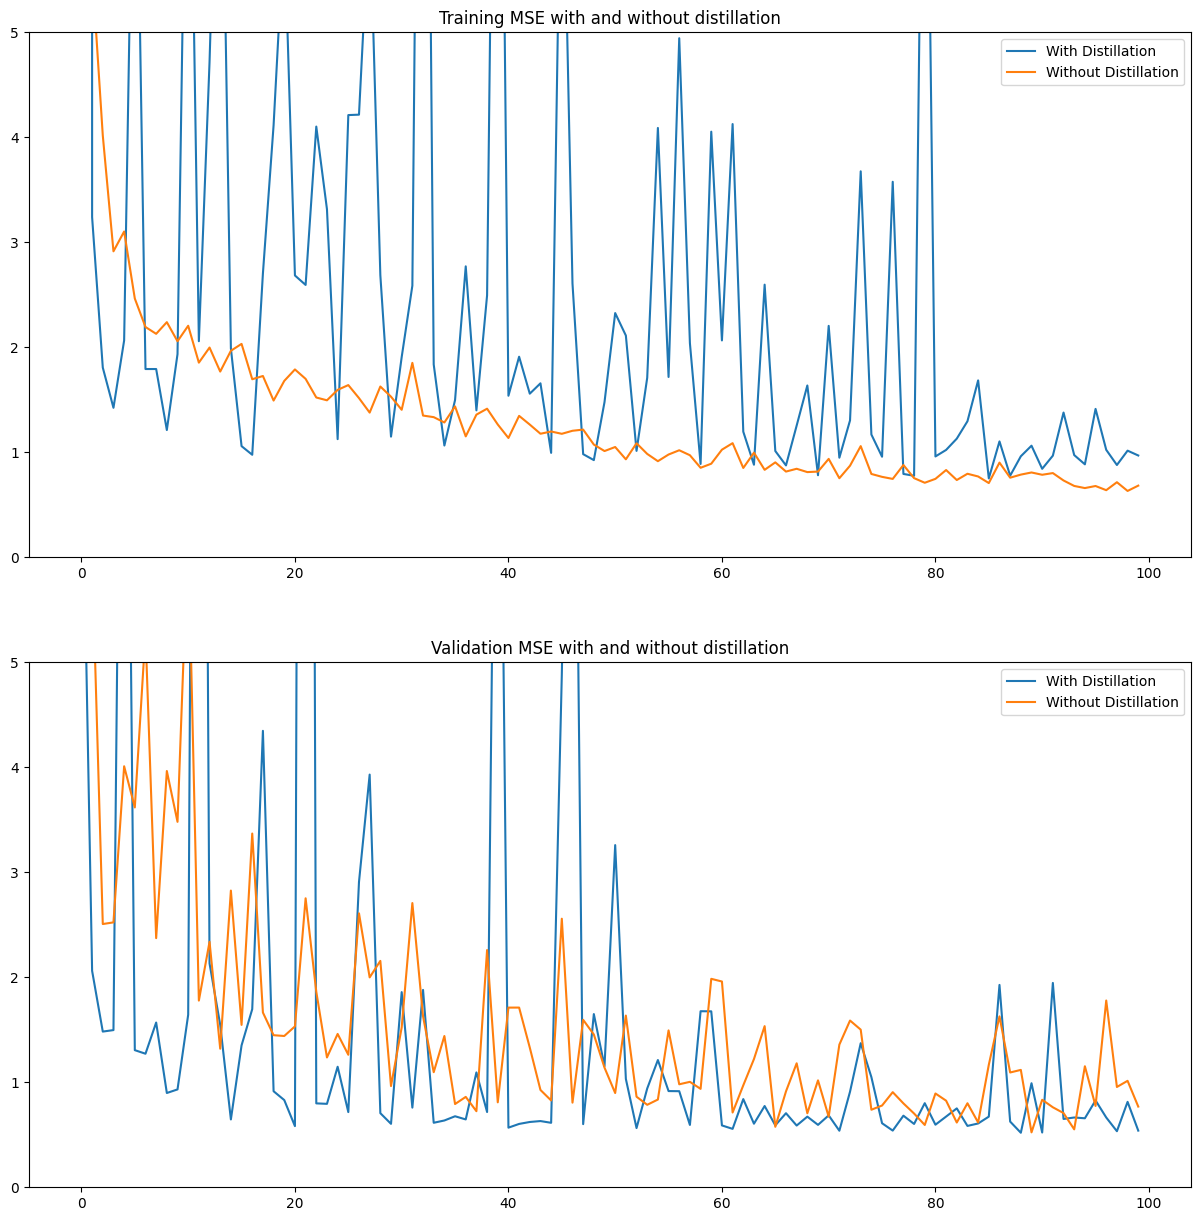

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.5657 +- 0.2371
Validation mse without disstillation 0.6397 +- 0.2034


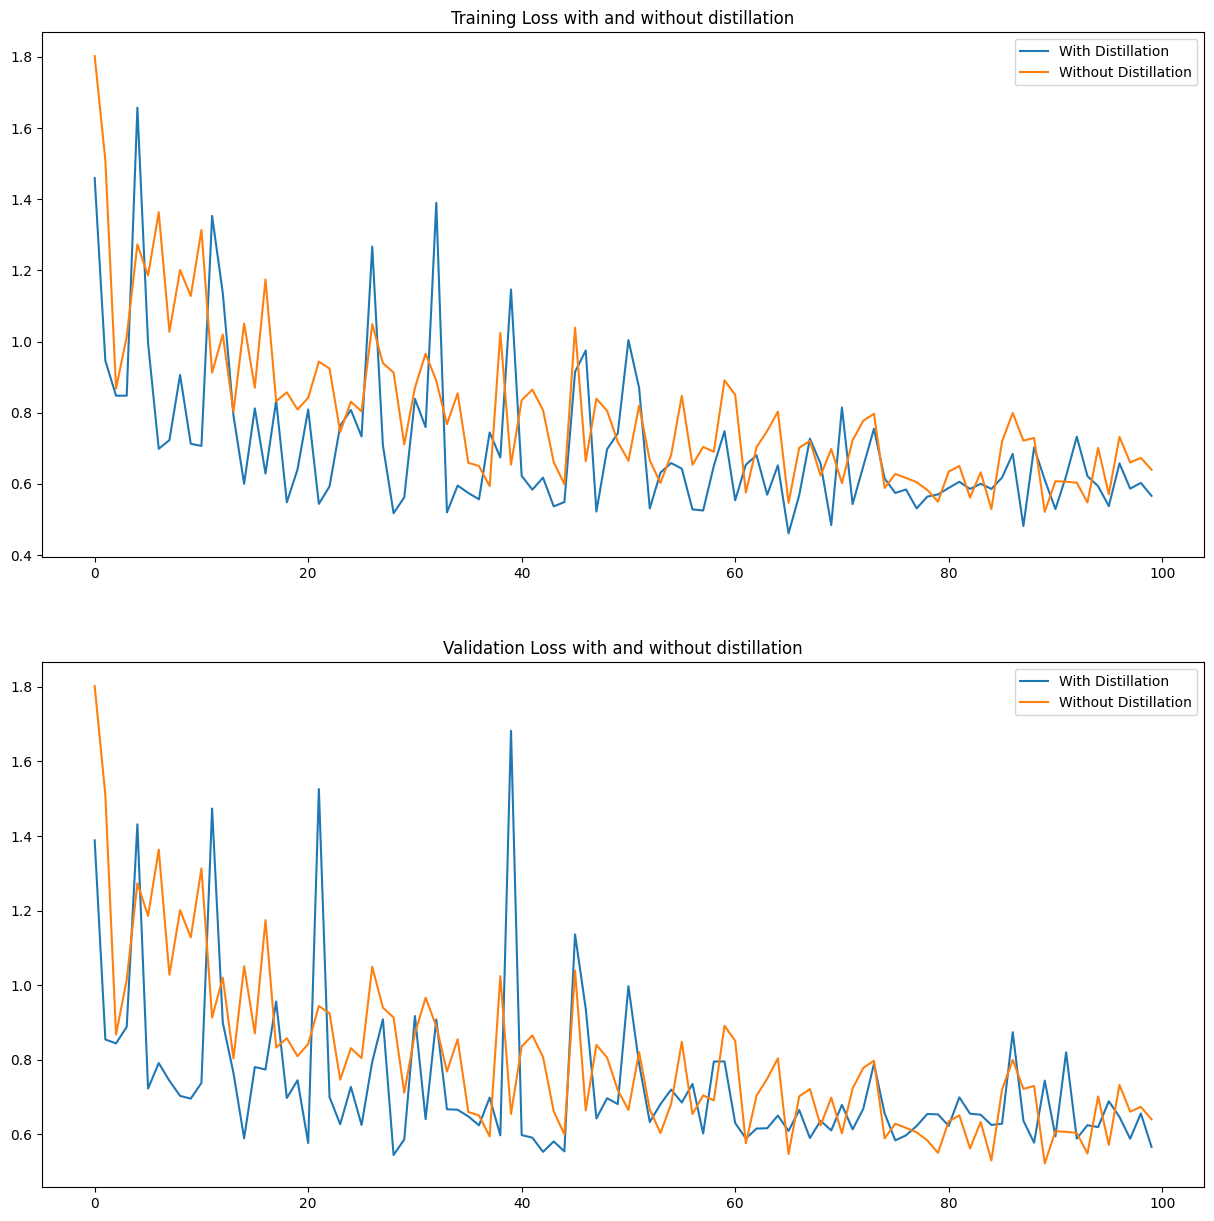

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [11]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 1s 2ms/step - mse: 1865.3245 - mae: 9.7914 - mape: 672.4150 - student_loss: 9.7611 - distillation_loss: 1859.7089
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 2.6129 - mae: 1.1659 - mape: 74.4865 - student_loss: 1.1641 - distillation_loss: 2.1801
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 1.7828 - mae: 1.0104 - mape: 65.3220 - student_loss: 1.0106 - distillation_loss: 1.3508
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 1.2601 - mae: 0.8560 - mape: 55.0294 - student_loss: 0.8553 - distillation_loss: 0.8370
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 1.2303 - mae: 0.8042 - mape: 52.5036 - student_loss: 0.8028 - distillation_loss: 0.8112
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 1.6393 - mae: 0.8449 - mape: 54.6538 - student_loss: 0.8448 - distillation_loss: 1.2224
Epoch 7/100
492/492 [

492/492 [==============================] - 1s 2ms/step - mse: 1.1979 - mae: 0.7094 - mape: 46.2264 - student_loss: 0.7091 - distillation_loss: 0.7807
Epoch 52/100
492/492 [==============================] - 1s 2ms/step - mse: 1.9049 - mae: 0.8227 - mape: 53.4095 - student_loss: 0.8213 - distillation_loss: 1.4885
Epoch 53/100
492/492 [==============================] - 1s 2ms/step - mse: 1.2260 - mae: 0.6988 - mape: 45.3937 - student_loss: 0.7001 - distillation_loss: 0.8080
Epoch 54/100
492/492 [==============================] - 1s 2ms/step - mse: 1.7835 - mae: 0.8041 - mape: 52.3845 - student_loss: 0.8033 - distillation_loss: 1.3768
Epoch 55/100
492/492 [==============================] - 1s 2ms/step - mse: 1.5042 - mae: 0.7453 - mape: 48.2082 - student_loss: 0.7483 - distillation_loss: 1.0892
Epoch 56/100
492/492 [==============================] - 1s 2ms/step - mse: 1.1603 - mae: 0.7750 - mape: 50.0390 - student_loss: 0.7775 - distillation_loss: 0.7572
Epoch 57/100
492/492 [=============

492/492 [==============================] - 1s 2ms/step - loss: 18.7854 - mse: 5966.0703 - mae: 18.7854 - mape: 1276.9028
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7300 - mse: 0.9507 - mae: 0.7300 - mape: 47.2435
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6641 - mse: 0.8199 - mae: 0.6641 - mape: 42.1050
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6377 - mse: 0.7372 - mae: 0.6377 - mape: 40.0313
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6446 - mse: 0.7670 - mae: 0.6446 - mape: 40.5088
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6544 - mse: 0.8029 - mae: 0.6544 - mape: 40.7502
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6354 - mse: 0.7365 - mae: 0.6354 - mape: 39.1731
Epoch 8/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6479 - mse: 0.7539 - mae: 0.6479 - mape: 40.44

492/492 [==============================] - 1s 2ms/step - loss: 0.5013 - mse: 0.4536 - mae: 0.5013 - mape: 30.4691
Epoch 66/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4980 - mse: 0.4569 - mae: 0.4980 - mape: 30.4038
Epoch 67/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4919 - mse: 0.4417 - mae: 0.4919 - mape: 30.1162
Epoch 68/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5009 - mse: 0.4542 - mae: 0.5009 - mape: 30.4693
Epoch 69/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4936 - mse: 0.4503 - mae: 0.4936 - mape: 29.8908
Epoch 70/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4924 - mse: 0.4407 - mae: 0.4924 - mape: 30.1518
Epoch 71/100
492/492 [==============================] - 1s 2ms/step - loss: 0.4999 - mse: 0.4625 - mae: 0.4999 - mape: 30.2854
Epoch 72/100
492/492 [==============================] - 1s 2ms/step - loss: 0.5023 - mse: 0.4591 - mae: 0.5023 - mape: 30.87

In [12]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 0.6345419883728027, 'mae': 0.5620515942573547, 'mape': 31.53135108947754, 'student_loss': 0.5469570755958557}
Test mse without disstillation {'loss': 0.5544863343238831, 'mse': 0.6108978390693665, 'mae': 0.5544863343238831, 'mape': 28.594661712646484}


In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
